Langkah 1: Memuat model dan tokenizer...
--> Model dan tokenizer berhasil dimuat.

Langkah 2: Memuat dan memproses data tes...
--> Data tes berhasil dimuat dan dipetakan.

Langkah 3: Melakukan tokenisasi dan padding pada data tes...
--> Data tes siap, bentuknya: (9169, 300)

Langkah 4: Melakukan prediksi dan evaluasi...
287/287 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step

================ HASIL EVALUASI MODEL PADA DATA TES ================

              precision    recall  f1-score   support

     Positif       0.98      0.91      0.94      6308
     Negatif       0.89      0.92      0.90      1445
      Netral       0.64      0.84      0.73      1416

    accuracy                           0.90      9169
   macro avg       0.84      0.89      0.86      9169
weighted avg       0.91      0.90      0.90      9169



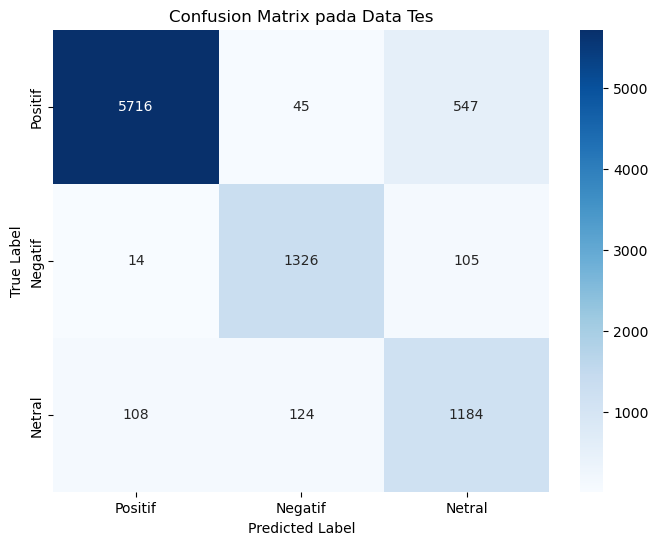

In [3]:
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- LANGKAH 1: MUAT MODEL DAN TOKENIZER YANG TERSIMPAN ---
print("Langkah 1: Memuat model dan tokenizer...")

# Definisikan class F1Score agar model bisa di-load
# Pastikan kode ini SAMA PERSIS dengan yang Anda gunakan saat training
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred_labels, sample_weight)
        self.recall.update_state(y_true, y_pred_labels, sample_weight)
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Muat model dengan custom object F1Score
model = load_model('bidirectional_lstm/bidirectional_lstm_model.h5', 
                   custom_objects={'F1Score': F1Score})

# Muat word_index yang tersimpan
with open('bidirectional_lstm/word_index.json', 'r') as file:
    word_index = json.load(file)

# Buat ulang tokenizer dan set word_index-nya
tokenizer = Tokenizer()
tokenizer.word_index = word_index

print("--> Model dan tokenizer berhasil dimuat.")


# --- LANGKAH 2: MUAT DAN PROSES DATASET TES BARU ---
print("\nLangkah 2: Memuat dan memproses data tes...")

# GANTI 'data_tes.csv' dengan nama file data tes Anda
df_test = pd.read_csv('datalabel/mbglabel.csv') 

# GANTI 'kolom_teks' dan 'kolom_sentimen' dengan nama kolom di file Anda
X_test = df_test['steming_data'].astype(str)
y_test_text = df_test['Sentiment']

# Buat pemetaan dari label teks ke angka (HARUS SAMA DENGAN SAAT TRAINING)
# Sesuaikan urutan ini jika pemetaan Anda berbeda
category_to_number = {'Positif': 0, 'Negatif': 1, 'Netral': 2}
y_test_numbered = y_test_text.map(category_to_number)

print("--> Data tes berhasil dimuat dan dipetakan.")


# --- LANGKAH 3: LAKUKAN PREPROCESSING YANG SAMA PERSIS ---
print("\nLangkah 3: Melakukan tokenisasi dan padding pada data tes...")

# GANTI nilai maxlen ini jika Anda menggunakan nilai yang berbeda saat training
maxlen = 300 

# Ubah teks menjadi sekuens angka menggunakan tokenizer yang sudah dimuat
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Lakukan padding dengan maxlen yang SAMA
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

print(f"--> Data tes siap, bentuknya: {X_test_pad.shape}")


# --- LANGKAH 4: LAKUKAN PREDIKSI DAN EVALUASI ---
print("\nLangkah 4: Melakukan prediksi dan evaluasi...")

# Lakukan prediksi
y_pred_proba = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Definisikan nama kelas sesuai pemetaan
class_names = ['Positif', 'Negatif', 'Netral']
labels_ordered = [0, 1, 2]

# Cetak Laporan Klasifikasi
print("\n================ HASIL EVALUASI MODEL PADA DATA TES ================\n")
print(classification_report(y_test_numbered, y_pred_classes, target_names=class_names, labels=labels_ordered))

# Buat dan Tampilkan Confusion Matrix
conf_matrix = confusion_matrix(y_test_numbered, y_pred_classes, labels=labels_ordered)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix pada Data Tes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [4]:
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- LANGKAH 1: MUAT MODEL DAN TOKENIZER ---
print("Memuat model dan tokenizer...")

# Definisikan kembali class F1Score agar model bisa di-load
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred_labels, sample_weight)
        self.recall.update_state(y_true, y_pred_labels, sample_weight)
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Muat model
model = load_model('bidirectional_lstm/bidirectional_lstm_model.h5', 
                   custom_objects={'F1Score': F1Score})

# Muat tokenizer
with open('bidirectional_lstm/word_index.json', 'r') as file:
    word_index = json.load(file)
tokenizer = Tokenizer()
tokenizer.word_index = word_index

print("--> Model dan tokenizer berhasil dimuat.")


# --- LANGKAH 2: MUAT DATA TES ---
print("\nMemuat data tes...")

# GANTI 'data_tes.csv' dengan nama file Anda
# Pastikan file ini memiliki kolom teks dan kolom label sentimen
df_test = pd.read_csv('datalabel/mbglabel.csv')

# GANTI 'kolom_teks' dan 'kolom_sentimen' dengan nama kolom Anda
X_test = df_test['steming_data'].astype(str)
y_test_actual_text = df_test['Sentiment']


# --- LANGKAH 3: PREPROCESSING DATA TES ---
print("\nMelakukan preprocessing...")

# GANTI nilai maxlen jika Anda menggunakan nilai yang berbeda saat training
maxlen = 150 
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')


# --- LANGKAH 4: LAKUKAN PREDIKSI ---
print("\nMelakukan prediksi...")
y_pred_proba = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_proba, axis=1)


# --- LANGKAH 5: BUAT DataFrame HASIL ---
print("\nMembuat DataFrame hasil...")

# Buat pemetaan dari angka ke label teks (kebalikan dari saat training)
# Sesuaikan ini jika pemetaan Anda berbeda
category_to_number = {'Positif': 0, 'Negatif': 1, 'Netral': 2}
index_to_category = {v: k for k, v in category_to_number.items()}

# Ubah prediksi angka menjadi teks
y_pred_text = np.array([index_to_category[pred] for pred in y_pred_classes])

# Buat DataFrame
results_df = pd.DataFrame({
    'steming_data': X_test,
    'Actual': y_test_actual_text,
    'Predicted': y_pred_text
})


# --- TAMPILKAN HASIL ---
print("\n================ HASIL PREDIKSI PADA DATA TES ================\n")
# Tampilkan 5 baris pertama dari hasil prediksi
print(results_df.head())

# (Opsional) Tampilkan 5 baris di mana prediksinya salah
print("\n\n================ CONTOH PREDIKSI YANG SALAH ================\n")
mismatched_predictions = results_df[results_df['Actual'] != results_df['Predicted']]
print(mismatched_predictions.head())

Memuat model dan tokenizer...
--> Model dan tokenizer berhasil dimuat.

Memuat data tes...

Melakukan preprocessing...

Melakukan prediksi...
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

Membuat DataFrame hasil...

================ HASIL PREDIKSI PADA DATA TES ================

                                        steming_data   Actual Predicted
0                         makan siang gratis mending  Positif   Positif
1  bela mbak bias sekolah makan siang gratis pas ...  Positif   Positif
2  anggar dituruninnya ngopernya blog ya dicicipi...  Positif   Positif
3  karyawan industri cikarang makan siang jemput ...  Positif   Positif
4  ambil abang ya makan siang gratis ya abang rol...  Positif   Positif


================ CONTOH PREDIKSI YANG SALAH ================

                                         steming_data   Actual Predicted
17               serangga menu makan siang gratis wow  Positif    Netral
27  triliun alokasi porsi turun rp15 ribu rp10 rib...  Negatif    Netral
57      

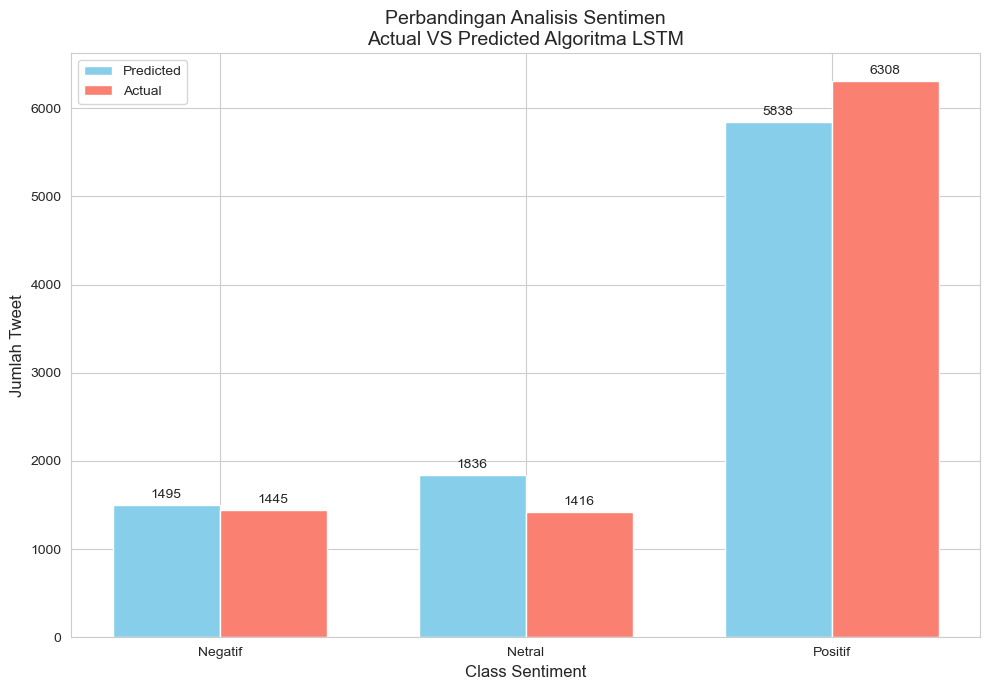

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- LANGKAH 1: Siapkan Data ---
# Di sini, Anda akan menggunakan DataFrame 'results_df' yang berisi hasil prediksi Anda.
# Saya akan membuat data contoh agar kode ini bisa berjalan.
# HAPUS BAGIAN INI jika Anda menjalankan di notebook yang sama.



# --- LANGKAH 2: Hitung Jumlah Aktual dan Prediksi per Kategori ---
actual_counts = results_df['Actual'].value_counts()
predicted_counts = results_df['Predicted'].value_counts()

# Gabungkan hasil hitungan ke dalam satu DataFrame
plot_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
}).fillna(0).astype(int)

# BARIS FILTER DIHAPUS: Sekarang semua kelas akan ditampilkan
# plot_df = plot_df.loc[['Negatif', 'Positif']] # <-- Baris ini dihapus


# --- LANGKAH 3: Buat Plot Batang (Bar Chart) ---
sns.set_style("whitegrid")
labels = plot_df.index.tolist() # -> ['Positif', 'Negatif', 'Netral']
x = np.arange(len(labels))  # Posisi label di sumbu x
width = 0.35  # Lebar setiap batang

fig, ax = plt.subplots(figsize=(10, 7))

# Membuat batang untuk 'Predicted'
rects1 = ax.bar(x - width/2, plot_df['Predicted'], width, label='Predicted', color='skyblue')

# Membuat batang untuk 'Actual'
rects2 = ax.bar(x + width/2, plot_df['Actual'], width, label='Actual', color='salmon')

# Menambahkan label, judul, dan legenda
ax.set_ylabel('Jumlah Tweet', fontsize=12)
ax.set_xlabel('Class Sentiment', fontsize=12)
ax.set_title('Perbandingan Analisis Sentimen\nActual VS Predicted Algoritma LSTM', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Menambahkan angka di atas setiap batang
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# Merapikan layout dan menampilkan plot
fig.tight_layout()
plt.show()